# Multiple record IDA and fragility calculation using OpenSeesPy and opseestools
#### Author: Orlando Arroyo
#### email: odarroyo@uc.cl

## Loading libraries

In [18]:
from openseespy.opensees import *
import matplotlib.pyplot as plt
import opseestools.analisis as an
import opseestools.utilidades as ut
import opseestools.Lib_frag as lf
import numpy as np
import multiprocessing
from joblib import Parallel, delayed
import os as os
import time
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Ground motion input information

In [19]:
#%% INFORMACION DE ENTRADA
# ======================================

# records is a list with the names of ground motion files stored in the same directory as this notebook script
# SpectrumFactor is a list with scale factors used to anchor the Sa of each record at the design acceleration of the building
# NSteps is the number of steps of each record
# DTs is the time step of each record
# nodes is a list of nodes to record information. In this case, the only node is the roof node.
# SFactor are scale factors to be applied (considering 1.0 when the ground motion is scaled to the design base earthquake)

records= ["GM01.txt", "GM02.txt", "GM03.txt", "GM04.txt", "GM05.txt", "GM06.txt", "GM07.txt", "GM08.txt", "GM09.txt", "GM10.txt", "GM11.txt", "GM12.txt", "GM13.txt", "GM14.txt", "GM15.txt",
         "GM16.txt", "GM17.txt", "GM18.txt", "GM19.txt", "GM20.txt", "GM21.txt", "GM22.txt", "GM23.txt", "GM24.txt", "GM25.txt", "GM26.txt", "GM27.txt", "GM28.txt", "GM29.txt", "GM30.txt",
          "GM31.txt", "GM32.txt", "GM33.txt", "GM34.txt", "GM35.txt", "GM36.txt", "GM37.txt", "GM38.txt", "GM39.txt", "GM40.txt", "GM41.txt", "GM42.txt", "GM43.txt", "GM44.txt"]
SpectrumFactor= [0.647426972,0.498726473,0.503999614,0.478161366,0.589546608,0.477704312,1.682467501,1.20620368,1.029770012,0.73124417,1.249838191,1.064764959,0.636741252,0.577270921,0.640404291,0.818394714,0.815874762,0.867515359,1.84137413,2.574316418,0.991379457,2.2349985,1.584584522,0.60577121,0.547166565,0.413121928,0.913989311,1.47252665,0.745693994,1.042030541,0.8533576,1.826641759,1.10171508,1.074092626,0.657668909,0.748815552,0.818734703,0.617128352,0.609401699,0.687171747,2.453660823,3.013166191,1.884958295,0.543088642]
Nsteps= [3000, 3000, 2000, 2000, 5590, 5590, 4535, 4535, 9995, 9995, 7810, 7810, 4100, 4100, 4100, 4100, 5440, 5440, 6000, 6000, 2200, 2200, 11190, 11190, 7995, 7995, 7990, 7990, 2680, 2300, 8000, 8000, 2230, 2230, 1800, 1800, 18000, 18000, 18000, 18000, 2800, 2800, 7270, 7270]
DTs= [0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.005,0.005,0.01,0.01,0.01,0.01,0.005,0.005,0.05,0.05,0.02,0.02,0.0025,0.0025,0.005,0.005,0.005,0.005,0.02,0.02,0.005,0.005,0.01,0.01,0.02,0.02,0.005,0.005,0.005,0.005,0.01,0.01,0.005,0.005]
GMcode = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43]
nodes = [2016]
SFactor = [0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,3.25,3.5,3.75,4.0,4.25,4.5,4.75,5.0]
nrecords = len(DTs)
dtecho = []
dtechomax = []
logFile('log.out','-noEcho')

## Building modeling

#### This section models a sixteen story RC wall building. Full details of the building can be found at: 
#### L. Ramos and M. A. Hube, “Seismic response of reinforced concrete wall buildings with nonlinear coupling slabs,” Eng Struct, vol. 234, p. 111888, May 2021, doi: 10.1016/J.ENGSTRUCT.2021.111888.

In [20]:
def rundyn(fact,ind):
    rec = str(ind+1) 
    factor = 9.81*fact
    nombre = str(int(factor/9.81*100))
    wipe()
    model('basic','-ndm',2,'-ndf',3)
    xloc = [0.0,9.15]
    yloc = [0.0,2.6,5.2,7.8,10.4,13.0,15.6,18.2,20.8,23.4,26.0,28.6,31.2,33.8,36.4,39.0,41.6]
    diafragma = 1 
    pushlimit = 0.015 
    pushtype = 2 
    modepush = 1 
    w = 797.5*2/9.15 
    rhobordeI = [0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012] # cuantia borde izquierdo en altura
    rhobordeD = [0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012] # cuantia borde derecho en altura
    rhoalma = [0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012] # cuantia alma en altura
    width = [0.3,1.175,1.175,1.175,1.175,1.175,1.175,0.3] # ancho de las macrofibras
    nfib = len(width)
    t1 = [7.5,0.3,0.3,0.3,0.3,0.3,0.3,0.3]
    t2 = [0.3,0.3,0.3,0.3,0.3,0.3,0.3,7.5]
    ta = [t1,t1,t1,t1,t1,t1,t1,t1,t1,t1,t1,t1,t1,t1,t1,t1]
    tb = [t2,t2,t2,t2,t2,t2,t2,t2,t2,t2,t2,t2,t2,t2,t2,t2]
    muro1 = [rhobordeI,rhobordeD,rhoalma,width,ta]
    muro2 = [rhobordeI,rhobordeD,rhoalma,width,tb]
    muros = [muro2,muro1]
    cMVLEM = 0.4 
    bv = 0.3 
    hv = 0.5 
    Av = bv*hv
    Iv = bv*hv**3/12
    Ev = 24000000.0
    ny = len(yloc)
    nx = len(xloc)
    for i in range(nx):
        for j in range(ny):
            nnode = 1000*(i+1)+j
            node(nnode,xloc[i],yloc[j])
    print('Nodos generados')
    empotrado = [1,1,1]
    grado2 = [1,1,0]
    fixY(0.0,*empotrado)
    print('Restricciones asignadas')
    if diafragma == 1:
        for j in range(1,ny):
            for i in range(1,nx):
                masternode = 1000 + j
                slavenode = 1000*(i+1) + j
                equalDOF(masternode,slavenode,1)
        print('Diafragmas asignados')
    mass(1001,81.3,81.3,0.0)
    mass(1002,81.3,81.3,0.0)
    mass(1003,81.3,81.3,0.0)
    mass(1004,81.3,81.3,0.0)
    mass(1005,81.3,81.3,0.0)
    mass(1006,81.3,81.3,0.0)
    mass(1007,81.3,81.3,0.0)
    mass(1008,81.3,81.3,0.0)
    mass(1009,81.3,81.3,0.0)
    mass(1010,81.3,81.3,0.0)
    mass(1011,81.3,81.3,0.0)
    mass(1012,81.3,81.3,0.0)
    mass(1013,81.3,81.3,0.0)
    mass(1014,81.3,81.3,0.0)
    mass(1015,81.3,81.3,0.0)
    mass(1016,81.3,81.3,0.0)
    mass(2001,81.3,81.3,0.0)
    mass(2002,81.3,81.3,0.0)
    mass(2003,81.3,81.3,0.0)
    mass(2004,81.3,81.3,0.0)
    mass(2005,81.3,81.3,0.0)
    mass(2006,81.3,81.3,0.0)
    mass(2007,81.3,81.3,0.0)
    mass(2008,81.3,81.3,0.0)
    mass(2009,81.3,81.3,0.0)
    mass(2010,81.3,81.3,0.0)
    mass(2011,81.3,81.3,0.0)
    mass(2012,81.3,81.3,0.0)
    mass(2013,81.3,81.3,0.0)
    mass(2014,81.3,81.3,0.0)
    mass(2015,81.3,81.3,0.0)
    mass(2016,81.3,81.3,0.0)
    fc = 35000.0
    ec = 0.002
    E = 1000*4300*(fc/1000)**0.5
    fcu = 0.1*fc
    ecu = 0.006   
    k=1.3
    fcc=fc*k
    ecc= 2*fcc/E
    fucc=0.2*fcc
    eucc=0.02
    Fy=420000.0
    Es=210000000.0
    uniaxialMaterial('Concrete01', 2, -fc, -ec, -fcu, -ecu)
    uniaxialMaterial('Concrete01', 1, -fcc, -ecc, -fucc, -eucc)
    uniaxialMaterial('Steel01', 4, Fy, Es, 0.01)
    ey = Fy/Es
    fu = 630000.0
    eult = 0.1
    uniaxialMaterial('Hysteretic',3,Fy,ey,fu,eult,0.05*Fy,0.11,-Fy,-ey,-fu,-eult,-0.05*Fy,-0.11,1.0,1.0,0.0,0.0)
    tagshear = 1000
    G = E*0.4
    uniaxialMaterial('Elastic',tagshear,G*1.5)
    lineal = 1
    geomTransf('Linear',lineal)
    pdelta = 2
    geomTransf('PDelta',pdelta)
    cor = 3
    geomTransf('Corotational',cor)
    concTags = [2,2,2,2,2,2,2,2]
    steelTags = [3,3,3,3,3,3,3,3]
    shearTags = [tagshear,tagshear,tagshear,tagshear,tagshear,tagshear,tagshear,tagshear]
    for i in range(nx):
        # se toma el muro actual y luego se sacan de el las propiedades
        mur = muros[i] # muro actual
        rbi = mur[0] # cuantia elemento borde izquierdo
        rbd = mur[1] # cuantia elemento borde derecho
        ra = mur[2] # cuantia del alma
        widths = mur[3] # ancho de las macrofibras
        thickness = mur[4] # espesor del muro
        rhou = [] 
        walltags = []      
        for j in range(ny-1):
            thick = thickness[j]
            nodeI = 1000*(i+1) + j
            nodeJ = 1000*(i+1) + (j+1)
            eltag = 1000*(i+1) + j
            walltags.append(eltag)
            for k in range(nfib):
                if k == 0:
                    rhou.append(rbi[j])
                elif k == nfib-1:
                    rhou.append(rbd[j])
                else:
                    rhou.append(ra[j])
            element('MVLEM',eltag, 0.0, nodeI,nodeJ, nfib, cMVLEM, '-thick', *thick, '-width', *widths, '-rho', *rhou, '-matConcrete', *concTags, '-matSteel', *steelTags, '-matShear',*shearTags)            
    print('Muros generados')
    tagvigas=[]
    for j in range(1,ny):
        for i in range(nx-1):
            nodeI = 1000*(i+1) + j
            nodeJ = 1000*(i+2) + j
            eltag = 100000*(i+1) + j
            tagvigas.append(eltag)
            element('elasticBeamColumn',eltag,nodeI,nodeJ,Av,Ev,Iv,lineal)
    print('vigas generadas')
    timeSeries('Linear', 1)
    pattern('Plain',1,1)
    load(1001,0.0,-797.5,0.0)
    load(1002,0.0,-797.5,0.0)
    load(1003,0.0,-797.5,0.0)
    load(1004,0.0,-797.5,0.0)
    load(1005,0.0,-797.5,0.0)
    load(1006,0.0,-797.5,0.0)
    load(1007,0.0,-797.5,0.0)
    load(1008,0.0,-797.5,0.0)
    load(1009,0.0,-797.5,0.0)
    load(1010,0.0,-797.5,0.0)
    load(1011,0.0,-797.5,0.0)
    load(1012,0.0,-797.5,0.0)
    load(1013,0.0,-797.5,0.0)
    load(1014,0.0,-797.5,0.0)
    load(1015,0.0,-797.5,0.0)
    load(1016,0.0,-797.5,0.0)

    load(2001,0.0,-797.5,0.0)
    load(2002,0.0,-797.5,0.0)
    load(2003,0.0,-797.5,0.0)
    load(2004,0.0,-797.5,0.0)
    load(2005,0.0,-797.5,0.0)
    load(2006,0.0,-797.5,0.0)
    load(2007,0.0,-797.5,0.0)
    load(2008,0.0,-797.5,0.0)
    load(2009,0.0,-797.5,0.0)
    load(2010,0.0,-797.5,0.0)
    load(2011,0.0,-797.5,0.0)
    load(2012,0.0,-797.5,0.0)
    load(2013,0.0,-797.5,0.0)
    load(2014,0.0,-797.5,0.0)
    load(2015,0.0,-797.5,0.0)
    load(2016,0.0,-797.5,0.0)
    an.gravedad()
    loadConst('-time',0.0)
    factoran = SpectrumFactor[ind]*factor
    t,techo = an.dinamicoIDA2(records[ind], DTs[ind], Nsteps[ind], 0.04, factoran, 0.025, 2016, 1,[0,2])
    wipe()
    return ind,fact,t,techo

## Running the analysis using multiple cores with the joblib module

In [ ]:
num_cores = multiprocessing.cpu_count() 
resultados = Parallel(n_jobs=num_cores)(delayed(rundyn)(ff,pp) for ff in SFactor for pp in GMcode) # loop paralelo
# resultados returns a tuple where each element is a list that has four items: index of the ground motion, the scale factor, time and roof displacement of each analysis

## Processing the results and showing the IDA curves

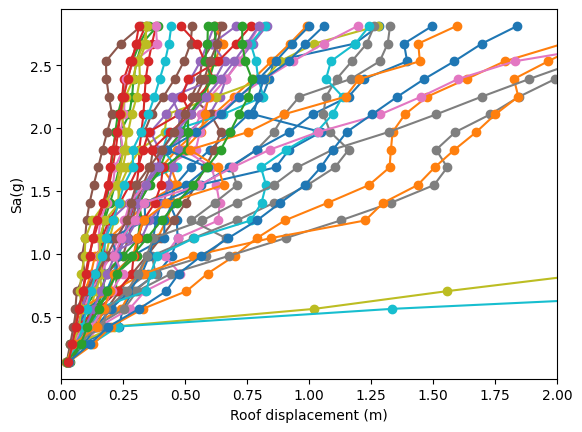

In [22]:
maxtecho2 = np.zeros(len(resultados))
maxt2 = np.zeros(len(resultados)) 
factor = np.zeros(len(resultados))
GMID = np.zeros(len(resultados))
                  
for indice,result in enumerate(resultados):
    dtecho = result[3]
    tiempo = result[2]
    maxtecho2[indice] = np.max(np.abs(dtecho))
    maxt2[indice] = np.max(tiempo)
    factor[indice] = result[1]*0.5625
    GMID[indice] = result[0]
Sa = np.array(SFactor)*0.5625
for k in range(44):
    s = maxtecho2[k::44]
    plt.plot(s,Sa,'o-')
plt.xlim([0,2])    
plt.ylabel('Sa(g)')
plt.xlabel('Roof displacement (m)')
plt.show()

## Storing results in a DataFrame and calculating fragility functions

#### This section stores the results in a Pandas Dataframe. Then, four limits are considered and the fragility function is calculated for each limit

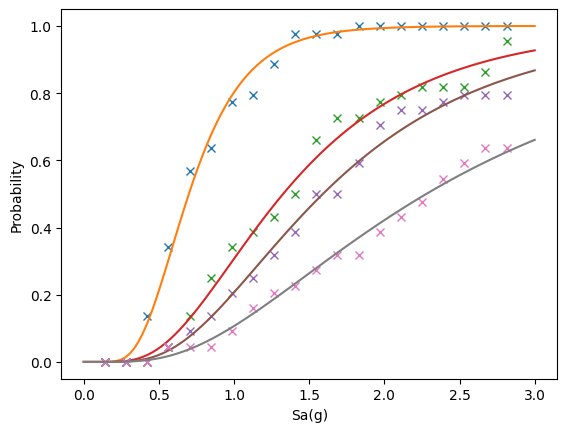

In [23]:
dic = {'Sa': factor, 'maxtecho': maxtecho2, 'GM': GMID}
df = pd.DataFrame(dic)
limit_name = ['ds1','ds2','ds3','ds4']
limits = np.array([0.004,0.008,0.01,0.015])*41.6

thetas, betas = lf.calculate_fragility(df, limit_name, limits, 'Sa', 'maxtecho')    


In [24]:
print(thetas)
print(betas)

[0.6988661301601681, 1.3259621543473825, 1.5905863113218777, 2.278728249356849]
[0.42043419003952287, 0.5608496889323902, 0.5687151060090538, 0.6626800905071234]


In [28]:
aa = df.groupby('Sa')[['ds1','ds2','ds3','ds4']].mean().reset_index()


In [ ]:
aa[vul]